# LSTM-Speech Classifier
This is a notebook to train LSTM model

In [176]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchaudio
from torch.autograd import Variable
import sys

import matplotlib.pyplot as plt
import IPython.display as ipd

from tqdm import tqdm

show a waveform sample

tensor([[0., 0., 0.,  ..., 0., 0., 0.]])


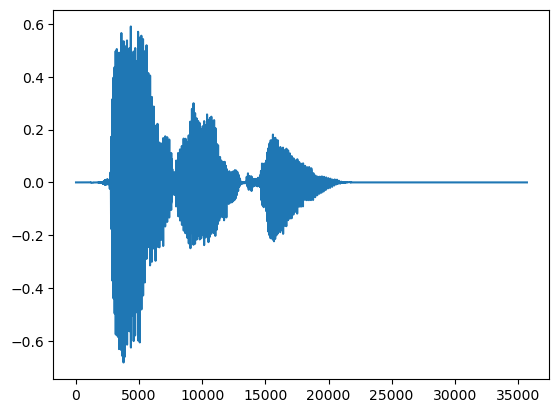

In [177]:
import os

DatasetFilePath = "/Users/xuhuan/Desktop/voicement desensitization/TextDataset/VoiceData"
waveform, sr = torchaudio.load(filepath=DatasetFilePath + "/sensitive/0.wav", frame_offset=0 , num_frames=-1, normalize=True, channels_first=True)
print(waveform)
plt.plot(waveform.t().numpy())

## Importing the dataset

In [178]:
X = []
y = []
NonDatasetFilePath = "/Users/xuhuan/Desktop/voicement desensitization/TextDataset/VoiceData/nonsensitive"
SenDatasetFilePath = "/Users/xuhuan/Desktop/voicement desensitization/TextDataset/VoiceData/sensitive"
for root, dirs, files in os.walk(SenDatasetFilePath):
    for f in files:
        if f.endswith(".wav"):
            waveform, sr = torchaudio.load(filepath=(SenDatasetFilePath + "/" + f), frame_offset=0 , num_frames=-1, normalize=True, channels_first=True)
            X.append(waveform)
            y.append("sensitive")
            # X.append(waveform)
            # y.append("sensitive")
for root, dirs, files in os.walk(NonDatasetFilePath):
    for f in files:
        if f.endswith(".wav"):
            waveform, sr = torchaudio.load(filepath=(NonDatasetFilePath + "/" + f), frame_offset=0 , num_frames=-1, normalize=True, channels_first=True)
            X.append(waveform)
            y.append("nonsensitive")
X = X + X
y = y + y
NumberofSensitiveData = y.count('sensitive')
print('There are %d sensitive data' % NumberofSensitiveData)
print('There are %d nonsensitive data' % (len(y) - NumberofSensitiveData))

There are 974 sensitive data
There are 1470 nonsensitive data


Divide dataset into training set and testing set

In [179]:
from sklearn import model_selection
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size = 0.2)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [180]:
from torch.utils.data import Dataset

class TensorDataset(Dataset):
    def __init__(self, data_tensor, target_tensor):
        self.data_tensor = data_tensor
        self.target_tensor = target_tensor

    def __getitem__(self, index):
        return self.data_tensor[index], self.target_tensor[index]

    def __len__(self):
        return len(self.data_tensor)

train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)

# get the size of the dataset
print(len(train_dataset))
print(len(test_dataset))


1955
489


In [181]:
labels = sorted(list(set(datapoint[1] for datapoint in train_dataset)))
labels

['nonsensitive', 'sensitive']

## Formatting Data
This is a good place to apply transformations to the data. For the waveform, we downsample the audio for faster processing without losing too much of the classification power.

In [182]:
new_sample_rate = 8000
transform = torchaudio.transforms.Resample(new_freq=new_sample_rate)
transformed = transform(waveform)

ipd.Audio(transformed.numpy(), rate=new_sample_rate)

In [183]:
def label_to_index(word):
    # Return the position of the word in labels
    return torch.tensor(labels.index(word))


def index_to_label(index):
    # Return the word corresponding to the index in labels
    # This is the inverse of label_to_index
    return labels[index]


word_start = "sensitive"
index = label_to_index(word_start)
word_recovered = index_to_label(index)

print(word_start, "-->", index, "-->", word_recovered)

sensitive --> tensor(1) --> sensitive


In [184]:
def pad_sequence(batch):
    # Make all tensor in a batch the same length by padding with zeros
    batch = [item.t() for item in batch]
    batch = torch.nn.utils.rnn.pad_sequence(batch, batch_first=True, padding_value=0.)
    return batch.permute(0, 2, 1)


def collate_fn(batch):

    # A data tuple has the form:
    # waveform, sample_rate, label, speaker_id, utterance_number

    tensors, targets = [], []

    # Gather in lists, and encode labels as indices
    for waveform, label in batch:
        tensors += [waveform]
        targets += [label_to_index(label)]

    # Group the list of tensors into a batched tensor
    tensors = pad_sequence(tensors)
    targets = torch.stack(targets)

    return tensors, targets


batch_size = 1
num_workers = 0

train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    collate_fn=collate_fn,
    num_workers=num_workers,
    pin_memory=False,
)
test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False,
    drop_last=False,
    collate_fn=collate_fn,
    num_workers=num_workers,
    pin_memory=False,
)

## Create LSTM Model

In [185]:
batch_first = True # 输入形式：(batch, seq, feature)
bidirectional = True
bidirectional_set  = True
bidirectional = 2 if bidirectional_set else 1
num_layers = 2
input_size = 64
hidden_size = 32
lstm_seq = nn.LSTM(input_size, hidden_size, num_layers=num_layers,bidirectional=bidirectional_set,batch_first=True)  # 构建LSTM网络
lstm_input = Variable(torch.randn(1, 1, input_size))  # 构建输入
h_init = Variable(torch.randn(num_layers*bidirectional, lstm_input.size(0), hidden_size))  # 构建h输入参数
c_init = Variable(torch.randn(num_layers*bidirectional, lstm_input.size(0), hidden_size))  # 构建c输出参数
out, (h, c) = lstm_seq(lstm_input, (h_init, c_init))  # 计算
print(lstm_seq.weight_ih_l0.shape)
print(lstm_seq.weight_hh_l0.shape)
print(out.shape, h.shape, c.shape)

torch.Size([128, 64])
torch.Size([128, 32])
torch.Size([1, 1, 64]) torch.Size([4, 1, 32]) torch.Size([4, 1, 32])


In [186]:
class LSTM(nn.Module):
    def __init__(self, n_input=1, n_output=35, stride=16, n_channel=32, hidden_dim=32):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.conv1 = nn.Conv1d(n_input, n_channel, kernel_size=80, stride=stride)
        self.bn1 = nn.BatchNorm1d(n_channel)
        self.pool1 = nn.MaxPool1d(4)
        self.conv2 = nn.Conv1d(n_channel, 2 * n_channel, kernel_size=3)
        self.bn2 = nn.BatchNorm1d(2 * n_channel)
        self.pool2 = nn.MaxPool1d(4)
        self.lstm = nn.LSTM(2 * n_channel, hidden_dim)
        bidirectional_set  = True
        num_layers = 2
        input_size = 64
        hidden_size = 32
        self.lstm_seq = nn.LSTM(input_size, hidden_size, num_layers=num_layers,bidirectional=bidirectional_set,batch_first=True)  # 构建LSTM网络
        # lstm_input = Variable(torch.randn(1, 1, input_size))  # 构建输入
        # h_init = Variable(torch.randn(num_layers*bidirectional, lstm_input.size(0), hidden_size))  # 构建h输入参数
        # c_init = Variable(torch.randn(num_layers*bidirectional, lstm_input.size(0), hidden_size))  # 构建c输出参数
        # out, (h, c) = lstm_seq(lstm_input, (h_init, c_init))  # 计算
        self.fc1 = nn.Linear(2 * n_channel, n_output)
    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(self.bn1(x))
        x = self.pool1(x)
        x = self.conv2(x)
        x = F.relu(self.bn2(x))
        x = self.pool2(x)
        x = F.avg_pool1d(x, x.shape[-1])
        x = x.permute(0, 2, 1)
        x, (ht, ct) = self.lstm_seq(x)
        x = self.fc1(x)
        return F.log_softmax(x, dim=2)


model = LSTM(n_input=transformed.shape[0], n_output=len(labels))
model.to(device)
print(model)


def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


n = count_parameters(model)
print("Number of parameters: %s" % n)

LSTM(
  (conv1): Conv1d(1, 32, kernel_size=(80,), stride=(16,))
  (bn1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv1d(32, 64, kernel_size=(3,), stride=(1,))
  (bn2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (lstm): LSTM(64, 32)
  (lstm_seq): LSTM(64, 32, num_layers=2, batch_first=True, bidirectional=True)
  (fc1): Linear(in_features=64, out_features=2, bias=True)
)
Number of parameters: 71842


In [187]:
optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=0.0001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.1)  # reduce the learning after 20 epochs by a factor of 10

In [188]:
def train(model, epoch, log_interval):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):

        data = data.to(device)
        target = target.to(device)

        # apply transform and model on whole batch directly on device
        data = transform(data)
        output = model(data)
        #print(output.squeeze(), target)
        # negative log-likelihood for a tensor of size (batch x 1 x n_output)
        loss = F.nll_loss(torch.squeeze(output, dim=0), target)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # print training stats
        if batch_idx % log_interval == 0:
            print(f"Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)} ({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}")

        # update progress bar
        pbar.update(pbar_update)
        # record loss
        losses.append(loss.item())

In [189]:
def number_of_correct(pred, target):
    # count number of correct predictions
    return pred.squeeze().eq(target).sum().item()


def get_likely_index(tensor):
    # find most likely label index for each element in the batch
    return tensor.argmax(dim=-1)


def test(model, epoch):
    model.eval()
    correct = 0
    for data, target in test_loader:

        data = data.to(device)
        target = target.to(device)

        # apply transform and model on whole batch directly on device
        data = transform(data)
        output = model(data)

        pred = get_likely_index(output)
        correct += number_of_correct(pred, target)

        # update progress bar
        pbar.update(pbar_update)
        print(f"\nTest Epoch: {epoch}\tAccuracy: {correct}/{len(test_loader.dataset)} ({100. * correct / len(test_loader.dataset):.0f}%)\n")

In [190]:
log_interval = 20
n_epoch = 2

pbar_update = 1 / (len(train_loader) + len(test_loader))
losses = []

# The transform needs to live on the same device as the model and the data.
transform = transform.to(device)
with tqdm(total=n_epoch) as pbar:
    for epoch in range(1, n_epoch + 1):
        train(model, epoch, log_interval)
        test(model, epoch)
        scheduler.step()

  0%|          | 0/2 [00:00<?, ?it/s]

Train Epoch: 1 [0/1955 (0%)]	Loss: 0.674770


  1%|          | 0.010638297872340429/2 [00:00<00:36, 18.28s/it]

Train Epoch: 1 [20/1955 (1%)]	Loss: 0.721735


  1%|          | 0.01718494271685762/2 [00:00<00:33, 17.05s/it] 

Train Epoch: 1 [40/1955 (2%)]	Loss: 0.530759


  1%|          | 0.02373158756137479/2 [00:00<00:32, 16.34s/it]

Train Epoch: 1 [60/1955 (3%)]	Loss: 0.258783


  2%|▏         | 0.03846153846153842/2 [00:00<00:29, 14.84s/it]

Train Epoch: 1 [80/1955 (4%)]	Loss: 0.613994


  2%|▏         | 0.045417348608837914/2 [00:00<00:28, 14.83s/it]

Train Epoch: 1 [100/1955 (5%)]	Loss: 0.600342


  3%|▎         | 0.052373158756137406/2 [00:00<00:28, 14.85s/it]

Train Epoch: 1 [120/1955 (6%)]	Loss: 0.528954


  3%|▎         | 0.060147299509001544/2 [00:00<00:27, 14.26s/it]

Train Epoch: 1 [140/1955 (7%)]	Loss: 0.271562


  3%|▎         | 0.06751227495908345/2 [00:01<00:27, 14.05s/it] 

Train Epoch: 1 [160/1955 (8%)]	Loss: 0.528926


  4%|▍         | 0.07569558101473005/2 [00:01<00:25, 13.51s/it]

Train Epoch: 1 [180/1955 (9%)]	Loss: 0.612680


  4%|▍         | 0.08346972176759432/2 [00:01<00:25, 13.47s/it]

Train Epoch: 1 [200/1955 (10%)]	Loss: 0.762158


  5%|▍         | 0.09124386252045859/2 [00:01<00:25, 13.60s/it]

Train Epoch: 1 [220/1955 (11%)]	Loss: 0.693715


  5%|▍         | 0.09901800327332286/2 [00:01<00:25, 13.57s/it]

Train Epoch: 1 [240/1955 (12%)]	Loss: 0.660758


  5%|▌         | 0.10679214402618713/2 [00:01<00:25, 13.64s/it]

Train Epoch: 1 [260/1955 (13%)]	Loss: 0.606610


  6%|▌         | 0.1145662847790514/2 [00:01<00:25, 13.66s/it] 

Train Epoch: 1 [280/1955 (14%)]	Loss: 0.845735


  6%|▌         | 0.12193126022913334/2 [00:01<00:26, 14.35s/it]

Train Epoch: 1 [300/1955 (15%)]	Loss: 0.862394


  7%|▋         | 0.1362520458265145/2 [00:01<00:27, 14.75s/it] 

Train Epoch: 1 [320/1955 (16%)]	Loss: 0.803164


  7%|▋         | 0.14443535188216083/2 [00:02<00:26, 14.04s/it]

Train Epoch: 1 [340/1955 (17%)]	Loss: 0.634175


  8%|▊         | 0.15180032733224252/2 [00:02<00:26, 14.10s/it]

Train Epoch: 1 [360/1955 (18%)]	Loss: 0.595117


  8%|▊         | 0.15916530278232421/2 [00:02<00:25, 14.01s/it]

Train Epoch: 1 [380/1955 (19%)]	Loss: 0.835004


  8%|▊         | 0.1665302782324059/2 [00:02<00:25, 13.92s/it] 

Train Epoch: 1 [400/1955 (20%)]	Loss: 0.524580


  9%|▊         | 0.1743044189852699/2 [00:02<00:25, 13.80s/it]

Train Epoch: 1 [420/1955 (21%)]	Loss: 0.946149


  9%|▉         | 0.18248772504091623/2 [00:02<00:24, 13.50s/it]

Train Epoch: 1 [440/1955 (23%)]	Loss: 0.972746


 10%|▉         | 0.19026186579378024/2 [00:02<00:24, 13.44s/it]

Train Epoch: 1 [460/1955 (24%)]	Loss: 0.903861


 10%|▉         | 0.19803600654664424/2 [00:02<00:24, 13.67s/it]

Train Epoch: 1 [480/1955 (25%)]	Loss: 0.879629


 10%|█         | 0.20540098199672593/2 [00:02<00:24, 13.76s/it]

Train Epoch: 1 [500/1955 (26%)]	Loss: 0.850572


 11%|█         | 0.21276595744680762/2 [00:03<00:25, 14.07s/it]

Train Epoch: 1 [520/1955 (27%)]	Loss: 0.840133


 11%|█         | 0.22013093289688931/2 [00:03<00:25, 14.10s/it]

Train Epoch: 1 [540/1955 (28%)]	Loss: 0.892467


 12%|█▏        | 0.2348608837970527/2 [00:03<00:24, 14.09s/it] 

Train Epoch: 1 [560/1955 (29%)]	Loss: 0.517667


 12%|█▏        | 0.2426350245499167/2 [00:03<00:24, 13.85s/it]

Train Epoch: 1 [580/1955 (30%)]	Loss: 0.950368


 13%|█▎        | 0.25040916530278073/2 [00:03<00:23, 13.67s/it]

Train Epoch: 1 [600/1955 (31%)]	Loss: 0.942719


 13%|█▎        | 0.2577741407528629/2 [00:03<00:23, 13.75s/it] 

Train Epoch: 1 [620/1955 (32%)]	Loss: 0.541550


 13%|█▎        | 0.2651391162029451/2 [00:03<00:23, 13.77s/it]

Train Epoch: 1 [640/1955 (33%)]	Loss: 0.950155


 14%|█▎        | 0.27291325695580965/2 [00:03<00:23, 13.64s/it]

Train Epoch: 1 [660/1955 (34%)]	Loss: 0.488107


 14%|█▍        | 0.28027823240589184/2 [00:03<00:25, 14.77s/it]

Train Epoch: 1 [680/1955 (35%)]	Loss: 0.460022


 14%|█▍        | 0.287643207855974/2 [00:04<00:24, 14.59s/it]  

Train Epoch: 1 [700/1955 (36%)]	Loss: 0.445733


 15%|█▍        | 0.29459901800327387/2 [00:04<00:24, 14.55s/it]

Train Epoch: 1 [720/1955 (37%)]	Loss: 1.000875


 15%|█▌        | 0.30851063829787356/2 [00:04<00:24, 14.64s/it]

Train Epoch: 1 [740/1955 (38%)]	Loss: 0.485661


 16%|█▌        | 0.31587561374795575/2 [00:04<00:24, 14.37s/it]

Train Epoch: 1 [760/1955 (39%)]	Loss: 0.462930


 16%|█▌        | 0.3236497545008203/2 [00:04<00:23, 14.09s/it] 

Train Epoch: 1 [780/1955 (40%)]	Loss: 0.455774


 17%|█▋        | 0.3310147299509025/2 [00:04<00:23, 14.30s/it]

Train Epoch: 1 [800/1955 (41%)]	Loss: 0.494113


 17%|█▋        | 0.33837970540098466/2 [00:04<00:25, 15.05s/it]

Train Epoch: 1 [820/1955 (42%)]	Loss: 0.867907


 17%|█▋        | 0.34574468085106685/2 [00:04<00:24, 14.82s/it]

Train Epoch: 1 [840/1955 (43%)]	Loss: 0.360207


 18%|█▊        | 0.35310965630114904/2 [00:05<00:23, 14.52s/it]

Train Epoch: 1 [860/1955 (44%)]	Loss: 0.758652


 18%|█▊        | 0.3608837970540136/2 [00:05<00:23, 14.18s/it] 

Train Epoch: 1 [880/1955 (45%)]	Loss: 0.396681


 18%|█▊        | 0.36824877250409577/2 [00:05<00:25, 15.64s/it]

Train Epoch: 1 [900/1955 (46%)]	Loss: 0.845073


 19%|█▉        | 0.3752045826513956/2 [00:05<00:25, 15.58s/it] 

Train Epoch: 1 [920/1955 (47%)]	Loss: 0.900639


 19%|█▉        | 0.38952536824877765/2 [00:05<00:24, 15.12s/it]

Train Epoch: 1 [940/1955 (48%)]	Loss: 0.550447


 20%|█▉        | 0.3972995090016422/2 [00:05<00:23, 14.46s/it] 

Train Epoch: 1 [960/1955 (49%)]	Loss: 0.534772


 20%|██        | 0.40466448445172437/2 [00:05<00:23, 14.54s/it]

Train Epoch: 1 [980/1955 (50%)]	Loss: 0.570536


 21%|██        | 0.4116202945990242/2 [00:05<00:23, 14.63s/it] 

Train Epoch: 1 [1000/1955 (51%)]	Loss: 0.843932


 21%|██        | 0.4198036006546711/2 [00:06<00:22, 14.05s/it]

Train Epoch: 1 [1020/1955 (52%)]	Loss: 0.505480


 21%|██▏       | 0.4271685761047533/2 [00:06<00:22, 14.03s/it]

Train Epoch: 1 [1040/1955 (53%)]	Loss: 0.937243


 22%|██▏       | 0.43535188216040016/2 [00:06<00:21, 13.46s/it]

Train Epoch: 1 [1060/1955 (54%)]	Loss: 0.915317


 22%|██▏       | 0.4431260229132647/2 [00:06<00:21, 13.66s/it] 

Train Epoch: 1 [1080/1955 (55%)]	Loss: 0.503482


 23%|██▎       | 0.4504909983633469/2 [00:06<00:21, 13.93s/it]

Train Epoch: 1 [1100/1955 (56%)]	Loss: 0.458457


 23%|██▎       | 0.4578559738134291/2 [00:06<00:22, 14.68s/it]

Train Epoch: 1 [1120/1955 (57%)]	Loss: 0.971110


 23%|██▎       | 0.46522094926351126/2 [00:06<00:22, 14.39s/it]

Train Epoch: 1 [1140/1955 (58%)]	Loss: 0.904551


 24%|██▎       | 0.47258592471359345/2 [00:06<00:22, 14.69s/it]

Train Epoch: 1 [1160/1955 (59%)]	Loss: 0.551743


 24%|██▍       | 0.48649754500819314/2 [00:07<00:23, 15.36s/it]

Train Epoch: 1 [1180/1955 (60%)]	Loss: 0.537459


 25%|██▍       | 0.49386252045827533/2 [00:07<00:22, 14.91s/it]

Train Epoch: 1 [1200/1955 (61%)]	Loss: 0.821810


 25%|██▌       | 0.5016366612111398/2 [00:07<00:21, 14.36s/it] 

Train Epoch: 1 [1220/1955 (62%)]	Loss: 0.593412


 25%|██▌       | 0.5094108019640043/2 [00:07<00:20, 13.90s/it]

Train Epoch: 1 [1240/1955 (63%)]	Loss: 0.589020


 26%|██▌       | 0.5167757774140865/2 [00:07<00:20, 13.83s/it]

Train Epoch: 1 [1260/1955 (64%)]	Loss: 0.833200


 26%|██▌       | 0.5241407528641687/2 [00:07<00:20, 13.88s/it]

Train Epoch: 1 [1280/1955 (65%)]	Loss: 0.596934


 27%|██▋       | 0.5319148936170333/2 [00:07<00:20, 13.71s/it]

Train Epoch: 1 [1300/1955 (66%)]	Loss: 0.608079


 27%|██▋       | 0.5474631751227623/2 [00:07<00:19, 13.37s/it]

Train Epoch: 1 [1320/1955 (68%)]	Loss: 0.840548


 28%|██▊       | 0.5552373158756269/2 [00:07<00:19, 13.33s/it]

Train Epoch: 1 [1340/1955 (69%)]	Loss: 0.866371


 28%|██▊       | 0.5630114566284914/2 [00:08<00:19, 13.23s/it]

Train Epoch: 1 [1360/1955 (70%)]	Loss: 0.923182


 29%|██▊       | 0.5707855973813559/2 [00:08<00:19, 13.71s/it]

Train Epoch: 1 [1380/1955 (71%)]	Loss: 0.541764


 29%|██▉       | 0.5789689034370028/2 [00:08<00:19, 13.46s/it]

Train Epoch: 1 [1400/1955 (72%)]	Loss: 0.914178


 29%|██▉       | 0.5867430441898673/2 [00:08<00:19, 13.72s/it]

Train Epoch: 1 [1420/1955 (73%)]	Loss: 0.500888


 30%|██▉       | 0.5941080196399495/2 [00:08<00:19, 13.86s/it]

Train Epoch: 1 [1440/1955 (74%)]	Loss: 0.952753


 30%|███       | 0.6014729950900317/2 [00:08<00:19, 14.17s/it]

Train Epoch: 1 [1460/1955 (75%)]	Loss: 0.968863


 30%|███       | 0.6088379705401139/2 [00:08<00:20, 14.73s/it]

Train Epoch: 1 [1480/1955 (76%)]	Loss: 1.001392


 31%|███       | 0.6170212765957608/2 [00:08<00:19, 13.99s/it]

Train Epoch: 1 [1500/1955 (77%)]	Loss: 1.028764
Train Epoch: 1 [1520/1955 (78%)]	Loss: 1.017109


 32%|███▏      | 0.6395253682487897/2 [00:09<00:19, 14.07s/it]

Train Epoch: 1 [1540/1955 (79%)]	Loss: 0.460877
Train Epoch: 1 [1560/1955 (80%)]	Loss: 0.454456


 33%|███▎      | 0.6554828150573011/2 [00:09<00:18, 13.69s/it]

Train Epoch: 1 [1580/1955 (81%)]	Loss: 0.991889
Train Epoch: 1 [1600/1955 (82%)]	Loss: 0.966381


 34%|███▎      | 0.6710310965630302/2 [00:09<00:17, 13.38s/it]

Train Epoch: 1 [1620/1955 (83%)]	Loss: 0.479709
Train Epoch: 1 [1640/1955 (84%)]	Loss: 1.006704


 34%|███▍      | 0.6873977086743239/2 [00:09<00:17, 13.35s/it]

Train Epoch: 1 [1660/1955 (85%)]	Loss: 1.003123
Train Epoch: 1 [1680/1955 (86%)]	Loss: 0.924621


 35%|███▌      | 0.7037643207856177/2 [00:09<00:16, 13.11s/it]

Train Epoch: 1 [1700/1955 (87%)]	Loss: 0.554352
Train Epoch: 1 [1720/1955 (88%)]	Loss: 0.871284


 36%|███▌      | 0.7197217675941291/2 [00:10<00:17, 13.81s/it]

Train Epoch: 1 [1740/1955 (89%)]	Loss: 0.878461
Train Epoch: 1 [1760/1955 (90%)]	Loss: 0.546615


 37%|███▋      | 0.7418166939443757/2 [00:10<00:18, 14.49s/it]

Train Epoch: 1 [1780/1955 (91%)]	Loss: 0.849570
Train Epoch: 1 [1800/1955 (92%)]	Loss: 0.553889


 38%|███▊      | 0.7561374795417577/2 [00:10<00:17, 14.21s/it]

Train Epoch: 1 [1820/1955 (93%)]	Loss: 0.562848
Train Epoch: 1 [1840/1955 (94%)]	Loss: 0.559901


 39%|███▊      | 0.7712765957447044/2 [00:10<00:17, 14.62s/it]

Train Epoch: 1 [1860/1955 (95%)]	Loss: 0.554004
Train Epoch: 1 [1880/1955 (96%)]	Loss: 0.532913


 39%|███▉      | 0.7851882160393041/2 [00:11<00:18, 14.89s/it]

Train Epoch: 1 [1900/1955 (97%)]	Loss: 0.541043
Train Epoch: 1 [1920/1955 (98%)]	Loss: 0.516068


 41%|████      | 0.818330605564674/2 [00:11<00:11,  9.76s/it] 

Train Epoch: 1 [1940/1955 (99%)]	Loss: 0.914702


 50%|█████     | 1.004091653027857/2 [00:12<00:05,  5.87s/it] 


Test Epoch: 1	Accuracy: 309/489 (63%)

Train Epoch: 2 [0/1955 (0%)]	Loss: 0.521105
Train Epoch: 2 [20/1955 (1%)]	Loss: 0.529952


 51%|█████     | 1.0212765957447107/2 [00:12<00:07,  7.90s/it]

Train Epoch: 2 [40/1955 (2%)]	Loss: 0.898990
Train Epoch: 2 [60/1955 (3%)]	Loss: 0.519672


 52%|█████▏    | 1.0482815057283381/2 [00:13<00:09,  9.96s/it]

Train Epoch: 2 [80/1955 (4%)]	Loss: 0.846294
Train Epoch: 2 [100/1955 (5%)]	Loss: 0.797628


 53%|█████▎    | 1.0597381342062406/2 [00:13<00:10, 10.67s/it]

Train Epoch: 2 [120/1955 (6%)]	Loss: 0.627459
Train Epoch: 2 [140/1955 (7%)]	Loss: 0.614428


 54%|█████▍    | 1.0793780687397878/2 [00:13<00:11, 12.08s/it]

Train Epoch: 2 [160/1955 (8%)]	Loss: 0.798892
Train Epoch: 2 [180/1955 (9%)]	Loss: 0.585131


 55%|█████▍    | 1.0965630114566416/2 [00:13<00:11, 12.80s/it]

Train Epoch: 2 [200/1955 (10%)]	Loss: 0.600293
Train Epoch: 2 [220/1955 (11%)]	Loss: 0.554465


 56%|█████▌    | 1.1125204582651487/2 [00:13<00:11, 13.34s/it]

Train Epoch: 2 [240/1955 (12%)]	Loss: 0.884668
Train Epoch: 2 [260/1955 (13%)]	Loss: 0.853916


 56%|█████▋    | 1.1280687397708735/2 [00:14<00:12, 13.86s/it]

Train Epoch: 2 [280/1955 (14%)]	Loss: 0.785489
Train Epoch: 2 [300/1955 (15%)]	Loss: 0.612402


 57%|█████▋    | 1.142798690671034/2 [00:14<00:11, 13.97s/it] 

Train Epoch: 2 [320/1955 (16%)]	Loss: 0.793211
Train Epoch: 2 [340/1955 (17%)]	Loss: 0.809028


 58%|█████▊    | 1.1575286415711943/2 [00:14<00:11, 13.93s/it]

Train Epoch: 2 [360/1955 (18%)]	Loss: 0.833849
Train Epoch: 2 [380/1955 (19%)]	Loss: 0.830785


 59%|█████▊    | 1.1730769230769191/2 [00:14<00:11, 13.40s/it]

Train Epoch: 2 [400/1955 (20%)]	Loss: 0.593242
Train Epoch: 2 [420/1955 (21%)]	Loss: 0.551322


 59%|█████▉    | 1.188625204582644/2 [00:14<00:10, 13.53s/it] 

Train Epoch: 2 [440/1955 (23%)]	Loss: 0.891497
Train Epoch: 2 [460/1955 (24%)]	Loss: 0.541949


 60%|██████    | 1.2041734860883688/2 [00:15<00:10, 13.73s/it]

Train Epoch: 2 [480/1955 (25%)]	Loss: 0.503140
Train Epoch: 2 [500/1955 (26%)]	Loss: 0.386653


 61%|██████    | 1.220130932896876/2 [00:15<00:10, 13.51s/it] 

Train Epoch: 2 [520/1955 (27%)]	Loss: 0.374879
Train Epoch: 2 [540/1955 (28%)]	Loss: 0.390663


 62%|██████▏   | 1.243044189852681/2 [00:15<00:10, 13.69s/it] 

Train Epoch: 2 [560/1955 (29%)]	Loss: 0.444864
Train Epoch: 2 [580/1955 (30%)]	Loss: 0.943031


 63%|██████▎   | 1.2585924713584058/2 [00:15<00:10, 13.55s/it]

Train Epoch: 2 [600/1955 (31%)]	Loss: 0.633430
Train Epoch: 2 [620/1955 (32%)]	Loss: 0.854178


 64%|██████▎   | 1.2737315875613484/2 [00:16<00:10, 14.93s/it]

Train Epoch: 2 [640/1955 (33%)]	Loss: 0.596701
Train Epoch: 2 [660/1955 (34%)]	Loss: 0.675388


 64%|██████▍   | 1.2876432078559443/2 [00:16<00:11, 15.49s/it]

Train Epoch: 2 [680/1955 (35%)]	Loss: 0.919930
Train Epoch: 2 [700/1955 (36%)]	Loss: 0.322081


 65%|██████▌   | 1.308101472995056/2 [00:16<00:10, 15.04s/it] 

Train Epoch: 2 [720/1955 (37%)]	Loss: 0.556997
Train Epoch: 2 [740/1955 (38%)]	Loss: 0.667322


 66%|██████▌   | 1.3224222585924341/2 [00:16<00:10, 14.91s/it]

Train Epoch: 2 [760/1955 (39%)]	Loss: 0.672781
Train Epoch: 2 [780/1955 (40%)]	Loss: 0.629222


 67%|██████▋   | 1.3375613747953767/2 [00:17<00:09, 14.11s/it]

Train Epoch: 2 [800/1955 (41%)]	Loss: 0.840223
Train Epoch: 2 [820/1955 (42%)]	Loss: 0.605472


 68%|██████▊   | 1.3527004909983193/2 [00:17<00:08, 13.88s/it]

Train Epoch: 2 [840/1955 (43%)]	Loss: 0.731474
Train Epoch: 2 [860/1955 (44%)]	Loss: 0.604775


 68%|██████▊   | 1.3686579378068264/2 [00:17<00:08, 13.56s/it]

Train Epoch: 2 [880/1955 (45%)]	Loss: 0.418800
Train Epoch: 2 [900/1955 (46%)]	Loss: 0.514870


 69%|██████▉   | 1.3842062193125513/2 [00:17<00:08, 13.62s/it]

Train Epoch: 2 [920/1955 (47%)]	Loss: 0.475314
Train Epoch: 2 [940/1955 (48%)]	Loss: 1.143730


 70%|███████   | 1.4063011456627919/2 [00:18<00:08, 14.37s/it]

Train Epoch: 2 [960/1955 (49%)]	Loss: 0.920937
Train Epoch: 2 [980/1955 (50%)]	Loss: 0.541232


 71%|███████   | 1.4218494271685167/2 [00:18<00:07, 13.71s/it]

Train Epoch: 2 [1000/1955 (51%)]	Loss: 0.532431
Train Epoch: 2 [1020/1955 (52%)]	Loss: 0.560965


 72%|███████▏  | 1.436579378068677/2 [00:18<00:07, 13.78s/it] 

Train Epoch: 2 [1040/1955 (53%)]	Loss: 0.595624
Train Epoch: 2 [1060/1955 (54%)]	Loss: 0.839616


 73%|███████▎  | 1.4517184942716197/2 [00:18<00:07, 13.62s/it]

Train Epoch: 2 [1080/1955 (55%)]	Loss: 0.831039
Train Epoch: 2 [1100/1955 (56%)]	Loss: 0.841508


 73%|███████▎  | 1.4672667757773445/2 [00:18<00:08, 15.14s/it]

Train Epoch: 2 [1120/1955 (57%)]	Loss: 0.873922
Train Epoch: 2 [1140/1955 (58%)]	Loss: 0.566444


 74%|███████▍  | 1.4811783960719405/2 [00:19<00:08, 15.43s/it]

Train Epoch: 2 [1160/1955 (59%)]	Loss: 0.559422
Train Epoch: 2 [1180/1955 (60%)]	Loss: 0.913482


 75%|███████▌  | 1.50490998363331/2 [00:19<00:06, 13.98s/it]  

Train Epoch: 2 [1200/1955 (61%)]	Loss: 0.442303
Train Epoch: 2 [1220/1955 (62%)]	Loss: 0.969023


 76%|███████▌  | 1.5200490998362526/2 [00:19<00:06, 13.89s/it]

Train Epoch: 2 [1240/1955 (63%)]	Loss: 0.501767
Train Epoch: 2 [1260/1955 (64%)]	Loss: 0.499879


 77%|███████▋  | 1.534779050736413/2 [00:19<00:06, 13.89s/it] 

Train Epoch: 2 [1280/1955 (65%)]	Loss: 0.478916
Train Epoch: 2 [1300/1955 (66%)]	Loss: 1.026194


 77%|███████▋  | 1.5499181669393556/2 [00:20<00:06, 14.17s/it]

Train Epoch: 2 [1320/1955 (68%)]	Loss: 0.438937
Train Epoch: 2 [1340/1955 (69%)]	Loss: 0.447893


 78%|███████▊  | 1.5650572831422982/2 [00:20<00:06, 13.88s/it]

Train Epoch: 2 [1360/1955 (70%)]	Loss: 1.029752
Train Epoch: 2 [1380/1955 (71%)]	Loss: 0.477262


 79%|███████▉  | 1.5814238952535875/2 [00:20<00:05, 13.83s/it]

Train Epoch: 2 [1400/1955 (72%)]	Loss: 0.455290
Train Epoch: 2 [1420/1955 (73%)]	Loss: 1.023751


 80%|████████  | 1.603518821603828/2 [00:20<00:05, 14.36s/it] 

Train Epoch: 2 [1440/1955 (74%)]	Loss: 1.026562
Train Epoch: 2 [1460/1955 (75%)]	Loss: 0.475685


 81%|████████  | 1.6182487725039885/2 [00:21<00:05, 14.97s/it]

Train Epoch: 2 [1480/1955 (76%)]	Loss: 0.953851
Train Epoch: 2 [1500/1955 (77%)]	Loss: 0.952835


 82%|████████▏ | 1.6325695581013666/2 [00:21<00:05, 14.54s/it]

Train Epoch: 2 [1520/1955 (78%)]	Loss: 0.492904
Train Epoch: 2 [1540/1955 (79%)]	Loss: 0.483180


 82%|████████▏ | 1.6477086743043092/2 [00:21<00:05, 14.20s/it]

Train Epoch: 2 [1560/1955 (80%)]	Loss: 0.478311
Train Epoch: 2 [1580/1955 (81%)]	Loss: 0.490418


 83%|████████▎ | 1.663256955810034/2 [00:21<00:04, 14.09s/it] 

Train Epoch: 2 [1600/1955 (82%)]	Loss: 0.516325
Train Epoch: 2 [1620/1955 (83%)]	Loss: 0.491294


 84%|████████▍ | 1.6861702127658391/2 [00:22<00:04, 13.62s/it]

Train Epoch: 2 [1640/1955 (84%)]	Loss: 0.491445
Train Epoch: 2 [1660/1955 (85%)]	Loss: 0.472382


 85%|████████▌ | 1.7029459901799107/2 [00:22<00:03, 12.92s/it]

Train Epoch: 2 [1680/1955 (86%)]	Loss: 0.464596
Train Epoch: 2 [1700/1955 (87%)]	Loss: 0.468631


 86%|████████▌ | 1.7197217675939822/2 [00:22<00:03, 12.62s/it]

Train Epoch: 2 [1720/1955 (88%)]	Loss: 1.003064
Train Epoch: 2 [1740/1955 (89%)]	Loss: 1.018209


 87%|████████▋ | 1.7364975450080538/2 [00:22<00:03, 12.65s/it]

Train Epoch: 2 [1760/1955 (90%)]	Loss: 0.960693
Train Epoch: 2 [1780/1955 (91%)]	Loss: 0.857219


 87%|████████▋ | 1.7446808510636984/2 [00:22<00:03, 12.97s/it]

Train Epoch: 2 [1800/1955 (92%)]	Loss: 0.532291
Train Epoch: 2 [1820/1955 (93%)]	Loss: 0.528059


 88%|████████▊ | 1.7680032733222857/2 [00:23<00:03, 13.63s/it]

Train Epoch: 2 [1840/1955 (94%)]	Loss: 0.823971
Train Epoch: 2 [1860/1955 (95%)]	Loss: 0.568996


 89%|████████▉ | 1.7839607201307928/2 [00:23<00:02, 13.27s/it]

Train Epoch: 2 [1880/1955 (96%)]	Loss: 0.588347
Train Epoch: 2 [1900/1955 (97%)]	Loss: 0.563271


 90%|████████▉ | 1.7999181669392998/2 [00:23<00:02, 13.04s/it]

Train Epoch: 2 [1920/1955 (98%)]	Loss: 0.912380
Train Epoch: 2 [1940/1955 (99%)]	Loss: 0.474580


100%|█████████▉| 1.9999999999998117/2 [00:24<00:00, 12.30s/it]


Test Epoch: 2	Accuracy: 309/489 (63%)

